In [2]:
import os
import pandas as pd

basel_dataset = pd.read_csv(os.path.join("dataset", "sorted", "BASEL.csv"))
basel_dataset


,DATE,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max
0,20000101,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9
1,20000102,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8
2,20000103,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8
3,20000104,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,7.5
4,20000105,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,8.6
...,...,...,...,...,...,...,...,...,...
3649,20091228,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,4.8
3650,20091229,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,10.0
3651,20091230,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,11.5
3652,20091231,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,7.9


In [6]:
import tensorflow as tf
import random
import numpy as np
import os
SEED = 1998
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

TRAIN_END_INDEX = 2922
VALIDATION_END_INDEX = 3288


def get_dataset(
    dataset: pd.DataFrame,
    sequence_length,
    batch_size,
    train_end_index,
    validation_end_index,
):
    data = dataset
    for col in dataset.columns:
        if "temp_mean" in col:
            target = pd.DataFrame(dataset[col])
            data = data.drop(columns=["DATE"])
            break
    train_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data[:-1],
        targets=target[1:],
        sequence_length=sequence_length,
        batch_size=batch_size,
        start_index=0,
        end_index=train_end_index,
    )
    validation_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data[:-sequence_length],
        targets=target[sequence_length:],
        sequence_length=sequence_length,
        batch_size=batch_size,
        start_index=train_end_index,
        end_index=validation_end_index,
    )
    test_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data[:-sequence_length],
        targets=target[sequence_length:],
        sequence_length=sequence_length,
        batch_size=batch_size,
        start_index=validation_end_index,
    )
    return (train_dataset, validation_dataset, test_dataset)

sequence_length = 6
(train_dataset, validation_dataset, test_dataset) = get_dataset(
    basel_dataset, sequence_length, 32, TRAIN_END_INDEX, VALIDATION_END_INDEX
)
print(train_dataset)
for data, label in train_dataset:
    print(data[0])
    print(label[0])
    feature_length = data.shape[2]
    break

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
tf.Tensor(
[[0.89   1.0286 0.2    0.03   0.     2.9    1.6    3.9   ]
 [0.87   1.0318 0.25   0.     0.     3.6    2.7    4.8   ]
 [0.81   1.0314 0.5    0.     3.7    2.2    0.1    4.8   ]
 [0.79   1.0262 0.63   0.35   6.9    3.9    0.5    7.5   ]
 [0.9    1.0246 0.51   0.07   3.7    6.     3.8    8.6   ]
 [0.85   1.0244 0.56   0.     5.7    4.2    1.9    6.9   ]], shape=(6, 8), dtype=float64)
tf.Tensor([3.6], shape=(1,), dtype=float64)


In [22]:
def get_simple_lstm(sequence_length, feature_length):
    model_in = tf.keras.Input((sequence_length, feature_length))
    x = tf.keras.layers.LSTM(16, return_sequences=True)(model_in)
    x = tf.keras.layers.LSTM(16)(x)
    model_out = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=[model_in], outputs=[model_out])



model = get_simple_lstm(sequence_length, feature_length)
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 8)]            0         
                                                                 
 lstm_5 (LSTM)               (None, 6, 16)             1600      
                                                                 
 lstm_6 (LSTM)               (None, 16)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,729
Trainable params: 3,729
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile("rmsprop", "MSE", ["MAE"])

loss: 3.4239 - MAE: 1.4237 - val_loss: 3.2621 - val_MAE: 1.4243
* sequence_length = 4
* lstm 1, unit 16

loss: 3.3885 - MAE: 1.4228 - val_loss: 3.1651 - val_MAE: 1.4173
* sequence_length = 6
* lstm 1, unit 16

loss: 3.5179 - MAE: 1.4533 - val_loss: 3.1334 - val_MAE: 1.4370
* sequence_length = 13
* lstm 1, unit 16

loss: 3.5020 - MAE: 1.4536 - val_loss: 2.9261 - val_MAE: 1.3783
* sequence_length = 6
* lstm 2, unit 16

loss: 3.5265 - MAE: 1.4641 - val_loss: 3.1694 - val_MAE: 1.4177
* sequence_length = 6
* lstm 2, unit 8

loss: 3.3421 - MAE: 1.4192 - val_loss: 3.2702 - val_MAE: 1.4447
* sequence_length = 6
* lstm 3, unit 16



In [5]:
max_epoch = 200
history = model.fit(
    train_dataset,
    epochs=max_epoch,
    validation_data=validation_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5),
        tf.keras.callbacks.ModelCheckpoint("model", save_best_only=True),
    ],
)


Epoch 1/200


2022-11-15 11:03:22.764721: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


92/92 [==============================] - ETA: 0s - loss: 126.8589 - MAE: 9.5225

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 18s 140ms/step - loss: 126.8589 - MAE: 9.5225 - val_loss: 65.6224 - val_MAE: 6.6151
Epoch 2/200
92/92 [==============================] - ETA: 0s - loss: 59.3804 - MAE: 6.2873

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 128ms/step - loss: 59.3804 - MAE: 6.2873 - val_loss: 44.8085 - val_MAE: 5.3770
Epoch 3/200
90/92 [============================>.] - ETA: 0s - loss: 46.0224 - MAE: 5.4296

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 125ms/step - loss: 45.6803 - MAE: 5.4091 - val_loss: 37.6834 - val_MAE: 4.9596
Epoch 4/200
91/92 [============================>.] - ETA: 0s - loss: 38.4447 - MAE: 4.9406

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 127ms/step - loss: 38.3840 - MAE: 4.9346 - val_loss: 32.0070 - val_MAE: 4.5800
Epoch 5/200
91/92 [============================>.] - ETA: 0s - loss: 32.8470 - MAE: 4.5507

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 128ms/step - loss: 32.7962 - MAE: 4.5456 - val_loss: 27.0075 - val_MAE: 4.2224
Epoch 6/200
92/92 [==============================] - ETA: 0s - loss: 28.1788 - MAE: 4.1986

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 128ms/step - loss: 28.1788 - MAE: 4.1986 - val_loss: 22.7821 - val_MAE: 3.9050
Epoch 7/200
92/92 [==============================] - ETA: 0s - loss: 24.1886 - MAE: 3.8697

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 128ms/step - loss: 24.1886 - MAE: 3.8697 - val_loss: 19.2999 - val_MAE: 3.6037
Epoch 8/200
91/92 [============================>.] - ETA: 0s - loss: 20.7545 - MAE: 3.5640

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 130ms/step - loss: 20.7243 - MAE: 3.5604 - val_loss: 16.4576 - val_MAE: 3.3395
Epoch 9/200
90/92 [============================>.] - ETA: 0s - loss: 17.9098 - MAE: 3.2966

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 134ms/step - loss: 17.8682 - MAE: 3.2955 - val_loss: 14.1613 - val_MAE: 3.1097
Epoch 10/200
92/92 [==============================] - ETA: 0s - loss: 15.5785 - MAE: 3.0744

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 125ms/step - loss: 15.5785 - MAE: 3.0744 - val_loss: 12.3653 - val_MAE: 2.9066
Epoch 11/200
91/92 [============================>.] - ETA: 0s - loss: 13.7886 - MAE: 2.8960

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 119ms/step - loss: 13.7702 - MAE: 2.8933 - val_loss: 10.9997 - val_MAE: 2.7394
Epoch 12/200
91/92 [============================>.] - ETA: 0s - loss: 12.3575 - MAE: 2.7449

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 122ms/step - loss: 12.3416 - MAE: 2.7424 - val_loss: 9.9228 - val_MAE: 2.6085
Epoch 13/200
92/92 [==============================] - ETA: 0s - loss: 11.1689 - MAE: 2.6105

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 129ms/step - loss: 11.1689 - MAE: 2.6105 - val_loss: 8.9974 - val_MAE: 2.4851
Epoch 14/200
90/92 [============================>.] - ETA: 0s - loss: 10.1456 - MAE: 2.4823

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 129ms/step - loss: 10.1426 - MAE: 2.4841 - val_loss: 8.1378 - val_MAE: 2.3526
Epoch 15/200
92/92 [==============================] - ETA: 0s - loss: 9.1996 - MAE: 2.3619

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 128ms/step - loss: 9.1996 - MAE: 2.3619 - val_loss: 7.3469 - val_MAE: 2.2242
Epoch 16/200
91/92 [============================>.] - ETA: 0s - loss: 8.3291 - MAE: 2.2450

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 128ms/step - loss: 8.3203 - MAE: 2.2434 - val_loss: 6.6290 - val_MAE: 2.1138
Epoch 17/200
92/92 [==============================] - ETA: 0s - loss: 7.5168 - MAE: 2.1322

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 130ms/step - loss: 7.5168 - MAE: 2.1322 - val_loss: 5.9472 - val_MAE: 1.9988
Epoch 18/200
90/92 [============================>.] - ETA: 0s - loss: 6.8041 - MAE: 2.0258

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 128ms/step - loss: 6.8057 - MAE: 2.0282 - val_loss: 5.3257 - val_MAE: 1.8842
Epoch 19/200
91/92 [============================>.] - ETA: 0s - loss: 6.2003 - MAE: 1.9345

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 125ms/step - loss: 6.1959 - MAE: 1.9336 - val_loss: 4.8022 - val_MAE: 1.7815
Epoch 20/200
91/92 [============================>.] - ETA: 0s - loss: 5.6926 - MAE: 1.8537

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 125ms/step - loss: 5.6895 - MAE: 1.8531 - val_loss: 4.3966 - val_MAE: 1.6907
Epoch 21/200
91/92 [============================>.] - ETA: 0s - loss: 5.2872 - MAE: 1.7885

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 128ms/step - loss: 5.2852 - MAE: 1.7882 - val_loss: 4.1042 - val_MAE: 1.6219
Epoch 22/200
92/92 [==============================] - ETA: 0s - loss: 4.9743 - MAE: 1.7356

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 131ms/step - loss: 4.9743 - MAE: 1.7356 - val_loss: 3.9037 - val_MAE: 1.5774
Epoch 23/200
92/92 [==============================] - ETA: 0s - loss: 4.7385 - MAE: 1.6943

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 124ms/step - loss: 4.7385 - MAE: 1.6943 - val_loss: 3.7687 - val_MAE: 1.5472
Epoch 24/200
90/92 [============================>.] - ETA: 0s - loss: 4.5549 - MAE: 1.6602

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 128ms/step - loss: 4.5571 - MAE: 1.6619 - val_loss: 3.6767 - val_MAE: 1.5273
Epoch 25/200
92/92 [==============================] - ETA: 0s - loss: 4.4134 - MAE: 1.6358

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 127ms/step - loss: 4.4134 - MAE: 1.6358 - val_loss: 3.6119 - val_MAE: 1.5121
Epoch 26/200
91/92 [============================>.] - ETA: 0s - loss: 4.2945 - MAE: 1.6135

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 129ms/step - loss: 4.2960 - MAE: 1.6141 - val_loss: 3.5640 - val_MAE: 1.5002
Epoch 27/200
91/92 [============================>.] - ETA: 0s - loss: 4.1959 - MAE: 1.5949

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 128ms/step - loss: 4.1977 - MAE: 1.5955 - val_loss: 3.5269 - val_MAE: 1.4912
Epoch 28/200
90/92 [============================>.] - ETA: 0s - loss: 4.1100 - MAE: 1.5781

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 129ms/step - loss: 4.1135 - MAE: 1.5794 - val_loss: 3.4968 - val_MAE: 1.4842
Epoch 29/200
91/92 [============================>.] - ETA: 0s - loss: 4.0383 - MAE: 1.5643

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 128ms/step - loss: 4.0403 - MAE: 1.5651 - val_loss: 3.4716 - val_MAE: 1.4786
Epoch 30/200
91/92 [============================>.] - ETA: 0s - loss: 3.9737 - MAE: 1.5514

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 127ms/step - loss: 3.9759 - MAE: 1.5522 - val_loss: 3.4501 - val_MAE: 1.4741
Epoch 31/200
92/92 [==============================] - ETA: 0s - loss: 3.9185 - MAE: 1.5403

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 126ms/step - loss: 3.9185 - MAE: 1.5403 - val_loss: 3.4313 - val_MAE: 1.4703
Epoch 32/200
91/92 [============================>.] - ETA: 0s - loss: 3.8648 - MAE: 1.5288

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 129ms/step - loss: 3.8670 - MAE: 1.5296 - val_loss: 3.4147 - val_MAE: 1.4676
Epoch 33/200
91/92 [============================>.] - ETA: 0s - loss: 3.8182 - MAE: 1.5188

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 125ms/step - loss: 3.8203 - MAE: 1.5196 - val_loss: 3.3999 - val_MAE: 1.4651
Epoch 34/200
90/92 [============================>.] - ETA: 0s - loss: 3.7732 - MAE: 1.5087

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 127ms/step - loss: 3.7778 - MAE: 1.5105 - val_loss: 3.3865 - val_MAE: 1.4631
Epoch 35/200
91/92 [============================>.] - ETA: 0s - loss: 3.7366 - MAE: 1.5013

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 127ms/step - loss: 3.7386 - MAE: 1.5022 - val_loss: 3.3743 - val_MAE: 1.4615
Epoch 36/200
91/92 [============================>.] - ETA: 0s - loss: 3.7004 - MAE: 1.4936

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 127ms/step - loss: 3.7023 - MAE: 1.4945 - val_loss: 3.3631 - val_MAE: 1.4600
Epoch 37/200
90/92 [============================>.] - ETA: 0s - loss: 3.6636 - MAE: 1.4854

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 126ms/step - loss: 3.6686 - MAE: 1.4874 - val_loss: 3.3527 - val_MAE: 1.4584
Epoch 38/200
92/92 [==============================] - ETA: 0s - loss: 3.6369 - MAE: 1.4808

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 128ms/step - loss: 3.6369 - MAE: 1.4808 - val_loss: 3.3430 - val_MAE: 1.4568
Epoch 39/200
92/92 [==============================] - ETA: 0s - loss: 3.6071 - MAE: 1.4745

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 126ms/step - loss: 3.6071 - MAE: 1.4745 - val_loss: 3.3338 - val_MAE: 1.4552
Epoch 40/200
92/92 [==============================] - ETA: 0s - loss: 3.5789 - MAE: 1.4684

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 130ms/step - loss: 3.5789 - MAE: 1.4684 - val_loss: 3.3252 - val_MAE: 1.4540
Epoch 41/200
90/92 [============================>.] - ETA: 0s - loss: 3.5467 - MAE: 1.4606

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 126ms/step - loss: 3.5521 - MAE: 1.4628 - val_loss: 3.3170 - val_MAE: 1.4528
Epoch 42/200
90/92 [============================>.] - ETA: 0s - loss: 3.5211 - MAE: 1.4551

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 127ms/step - loss: 3.5266 - MAE: 1.4574 - val_loss: 3.3092 - val_MAE: 1.4516
Epoch 43/200
90/92 [============================>.] - ETA: 0s - loss: 3.4968 - MAE: 1.4501

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 126ms/step - loss: 3.5023 - MAE: 1.4523 - val_loss: 3.3019 - val_MAE: 1.4505
Epoch 44/200
92/92 [==============================] - ETA: 0s - loss: 3.4791 - MAE: 1.4475

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 130ms/step - loss: 3.4791 - MAE: 1.4475 - val_loss: 3.2951 - val_MAE: 1.4495
Epoch 45/200
90/92 [============================>.] - ETA: 0s - loss: 3.4513 - MAE: 1.4407

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 124ms/step - loss: 3.4569 - MAE: 1.4430 - val_loss: 3.2889 - val_MAE: 1.4485
Epoch 46/200
90/92 [============================>.] - ETA: 0s - loss: 3.4300 - MAE: 1.4364

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 11s 125ms/step - loss: 3.4356 - MAE: 1.4387 - val_loss: 3.2834 - val_MAE: 1.4475
Epoch 47/200
92/92 [==============================] - ETA: 0s - loss: 3.4153 - MAE: 1.4345

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 129ms/step - loss: 3.4153 - MAE: 1.4345 - val_loss: 3.2788 - val_MAE: 1.4466
Epoch 48/200
91/92 [============================>.] - ETA: 0s - loss: 3.3957 - MAE: 1.4299

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 132ms/step - loss: 3.3958 - MAE: 1.4304 - val_loss: 3.2751 - val_MAE: 1.4461
Epoch 49/200
91/92 [============================>.] - ETA: 0s - loss: 3.3772 - MAE: 1.4261

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 129ms/step - loss: 3.3772 - MAE: 1.4266 - val_loss: 3.2724 - val_MAE: 1.4455
Epoch 50/200
91/92 [============================>.] - ETA: 0s - loss: 3.3595 - MAE: 1.4224

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 127ms/step - loss: 3.3593 - MAE: 1.4228 - val_loss: 3.2708 - val_MAE: 1.4452
Epoch 51/200
90/92 [============================>.] - ETA: 0s - loss: 3.3368 - MAE: 1.4170

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 12s 129ms/step - loss: 3.3421 - MAE: 1.4192 - val_loss: 3.2702 - val_MAE: 1.4447
Epoch 52/200
92/92 [==============================] - 2s 27ms/step - loss: 3.3257 - MAE: 1.4157 - val_loss: 3.2706 - val_MAE: 1.4449
Epoch 53/200
92/92 [==============================] - 2s 26ms/step - loss: 3.3099 - MAE: 1.4124 - val_loss: 3.2718 - val_MAE: 1.4454
Epoch 54/200
92/92 [==============================] - 2s 25ms/step - loss: 3.2946 - MAE: 1.4090 - val_loss: 3.2739 - val_MAE: 1.4458
Epoch 55/200
92/92 [==============================] - 2s 26ms/step - loss: 3.2800 - MAE: 1.4057 - val_loss: 3.2767 - val_MAE: 1.4462
Epoch 56/200
92/92 [==============================] - 2s 26ms/step - loss: 3.2659 - MAE: 1.4025 - val_loss: 3.2799 - val_MAE: 1.4463


Text(0.5, 1.0, 'Loss')

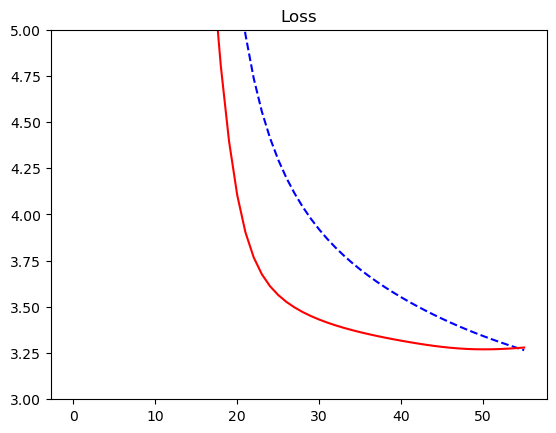

In [6]:
import matplotlib.pyplot as plt
epochs = len(history.history["loss"])
plt.plot(range(epochs), history.history["loss"], "b--")
plt.plot(range(epochs), history.history["val_loss"], "r")
plt.ylim(3, 5)
plt.title("Loss")

Text(0.5, 1.0, 'MAE')

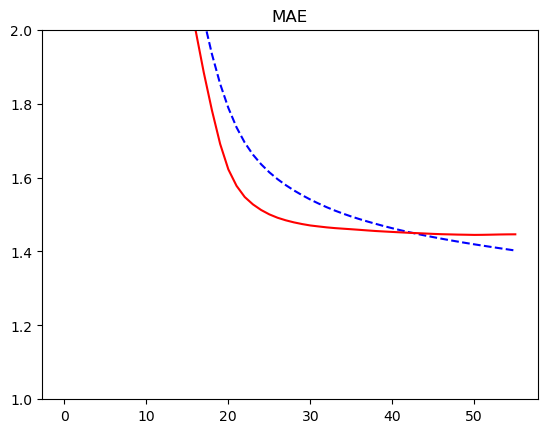

In [7]:
epochs = len(history.history["MAE"])
plt.plot(range(epochs), history.history["MAE"], "b--")
plt.plot(range(epochs), history.history["val_MAE"], "r")
plt.ylim(1, 2)
plt.title("MAE")

12/12 [==============================] - 1s 10ms/step


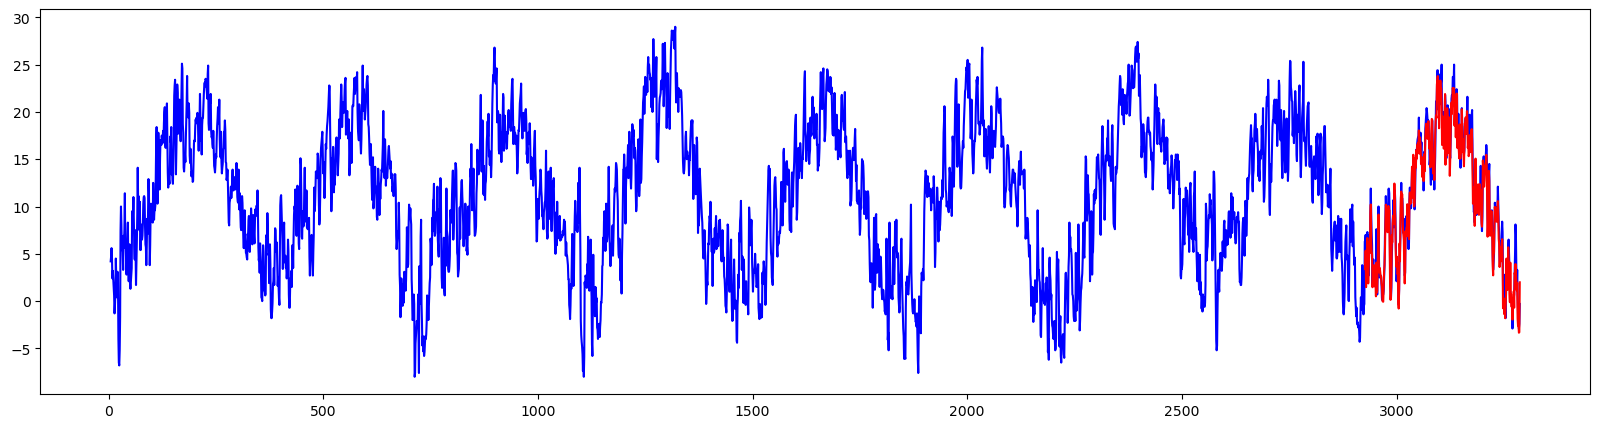

In [8]:
val_predictions = model.predict(validation_dataset)
import numpy as np
plt.figure(figsize=(20, 5))
plt.plot(
    range(sequence_length-1, VALIDATION_END_INDEX),
    basel_dataset.iloc[sequence_length-1 : VALIDATION_END_INDEX, 6],
    "b",
)
plt.plot(range(TRAIN_END_INDEX+sequence_length-1, VALIDATION_END_INDEX), val_predictions[:, 0], "r")
plt.show()


In [9]:
predictions = model.predict(validation_dataset)
predictions.shape


12/12 [==============================] - 0s 10ms/step


(361, 1)

In [10]:
for i in range(len(basel_dataset.index)):
    if "2008" in str(basel_dataset.iloc[i, 0]):
        print(i)
        break


2922


In [11]:
basel_dataset[2921:]


,DATE,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max
2921,20071231,0.86,1.0311,0.49,0.00,1.3,0.9,-2.4,4.9
2922,20080101,0.86,1.0257,0.22,0.00,0.0,-0.5,-2.2,0.9
2923,20080102,0.67,1.0181,0.25,0.00,0.0,-1.4,-2.1,-0.8
2924,20080103,0.68,1.0076,0.28,0.00,0.1,-0.5,-3.1,3.2
2925,20080104,0.80,1.0131,0.14,0.00,0.0,-0.3,-3.6,2.3
...,...,...,...,...,...,...,...,...,...
3649,20091228,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,4.8
3650,20091229,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,10.0
3651,20091230,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,11.5
3652,20091231,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,7.9


In [12]:
import numpy as np


def evaluate_naive_method(dataset):
    total_abs_err = 0
    data_seen = 0
    train_std = basel_dataset["BASEL_temp_mean"].std()
    train_mean = basel_dataset["BASEL_temp_mean"].mean()
    for data, label in dataset:
        preds = data[:, -1, 6] * train_std + train_mean
        total_abs_err += np.sum(np.abs(preds - label))
        data_seen += data.shape[0]
    return total_abs_err / data_seen


print("Navie Method Validation MAE:", evaluate_naive_method(validation_dataset))


Navie Method Validation MAE: 114.1731424485243


In [13]:
for data, label in validation_dataset:
    print(data.shape)


(32, 6, 8)
(32, 6, 8)
(32, 6, 8)
(32, 6, 8)
(32, 6, 8)
(32, 6, 8)
(32, 6, 8)
(32, 6, 8)
(32, 6, 8)
(32, 6, 8)
(32, 6, 8)
(9, 6, 8)
